In [3]:
import os,math
import rasterio
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as rxr
import geopandas as gpd
from glob import glob
from netCDF4 import Dataset
from functools import partial
from pyproj import CRS
from pyproj import Transformer
from shapely.geometry import Point, mapping
from shapely.ops import transform
from scipy.optimize import curve_fit

In [4]:
def geodesic_point_buffer(lat, lon, km):
    # Azimuthal equidistant projection
    aeqd_proj = f"+proj=aeqd +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0"
    transformer = Transformer.from_crs("EPSG:4326", aeqd_proj, always_xy=True)
    point = Point(lon, lat)
    point_aeqd = transform(transformer.transform, point)
    circle_aeqd = point_aeqd.buffer(km * 1000)
    return mapping(transform(partial(transformer.transform, direction="INVERSE"), circle_aeqd))

def rev_drct(x):
    drct = ['E','NE','N','NW','W','SW','S','SE']
    idx = drct.index(x)
    return drct[(idx+4)%len(drct)]

def fGauss(x,a,b,c,d):
    return a*np.exp(-b*(x-c)**2)+d

def fsigmoid(x, L, x0, k, b):
    return L/(1+np.exp(-k*(x-x0)))+b

In [6]:
ls_city = ['Atlanta','Austin','Charlotte','Cincinnati','Columbus','Dallas','Houston','Indianapolis','KC','Louisville',
           'Memphis','Miami','Minneapolis','Nashville','NYC','OKC','Omaha','Orlando','Phoenix','Pittsburgh',
           'Richmond','SanAntonio','StLouis','Tucson','Philadelphia','DC','Baltimore']
ls_lon = [-84.3880,-97.7431,-80.8431,-84.5120,-82.9988,-96.7970,-95.3698,-86.1581,-94.5786,-85.7585,-90.0490,
       -80.1918,-93.2650,-86.7816,-74.0060,-97.5164,-95.9345,-81.3789,-112.0740,-79.9959,-77.4360,-98.4936,-90.1994,
          -110.9747,-75.1652,-77.0369,-76.6122]
ls_lat = [33.7490,30.2672,35.2271,39.1031,39.9612,32.7767,29.7604,39.7684,39.0997,38.2527,35.1495,
       25.7617,44.9778,36.1627,40.7128,35.4676,41.2565,28.5384,33.4484,40.4406,37.5407,29.4241,38.6270,32.2226,39.9526,
         38.9072,39.2904]
ang_range = 45 # degree coverage for each direction

In [ ]:
## generate circles with different radius
os.chdir('/glade/scratch/USERNAME/MRMS_PrecipData')
precip_t2 = pd.read_csv('./T2Drct_SumPrecip60.csv',sep = ' ')

for i,city in enumerate(ls_city):
    lon = ls_lon[i]
    lat = ls_lat[i]
    ras = rxr.open_rasterio('./Precip_map/Wnd_Quantile/'+city+'_Precip60Q3.tif')
    #drct_t2 = precip_t2[precip_t2['City']==city]['Top 2 drct'].values[0]
    for buf_dis in np.arange(10,60,10):
        buffer = geodesic_point_buffer(lat,lon,buf_dis)
        new_ras = ras.rio.set_crs('WGS84').rio.clip([buffer])
        new_ras.rio.to_raster('./Precip_map/Wnd_Quantile/'+city+'_Precip'+str(buf_dis)+'Q3.tif')
        

In [ ]:
### upwind ring-based mean precipitation at top2 directions (non-normalized)
os.chdir('/glade/scratch/USERNAME/MRMS_PrecipData')
precip_t2 = pd.read_csv('./T2Drct_SumPrecip60.csv',sep = ' ')
drcts = ['E','NE','N','NW','W','SW','S','SE']

wind_val = [0,45,90,135,180,225,270,315]
ang_range = 45 # degree coverage of each wind direction

df_rPrecip = pd.DataFrame() # store final results

for i,city in enumerate(ls_city):
    tmp_count = [] # store number of valid grids within each slice, with a 10km increment in terms of radius
    tmp_AvgPrecip = [] # store mean precip within each slice, with a 10km increment in terms of radius
    res_AvgPrecip = [] # store mean precip within each 10km ring/slice.
    
    lon = ls_lon[i]
    lat = ls_lat[i]
    
    # list of rasters with radius from 10 to 60km
    ls_ras = sorted(glob('./Precip_map/'+city+'*'))
    
    ras10 = rxr.open_rasterio(ls_ras[0])
    ras10 = ras10[0]
    
    drct_t2 = precip_t2[precip_t2['City']==city]['Top 2 drct'].values[0]
    idx1 = drcts.index(drct_t2.split('+')[0])
    idx2 = drcts.index(drct_t2.split('+')[1])
    w1_upper = wind_val[idx1]+ang_range/2
    w1_lower = wind_val[idx1]-ang_range/2
    w2_upper = wind_val[idx2]+ang_range/2
    w2_lower = wind_val[idx2]-ang_range/2
    
    center_x = int(np.floor(ras10.x.size/2))
    center_y = int(np.floor(ras10.y.size/2))
    xmat = np.array([[x-ras10.x[center_x].values for x in ras10.x.values]]*len(ras10.y.values))
    ymat = np.array([[y-ras10.y[center_y].values for y in ras10.y.values]]*len(ras10.x.values)).T
    arr_ang = np.rad2deg(np.arctan2(ymat,xmat))
    arr_ang = np.array(arr_ang<0)*360+arr_ang
    
    ang_buffer = xr.DataArray(
            data = arr_ang,
            dims = ['y','x'], # control the x,y layout when plotting
            coords = dict(
            x = (['x'],ras10.x.values),
            y = (['y'],ras10.y.values),
            )
        )
    
    if w1_lower > 0 and w2_lower > 0:
        ras_masked = ras10.where(((ang_buffer>=w1_lower)&(ang_buffer<w1_upper))|((ang_buffer>=w2_lower)&(ang_buffer<w2_upper)))
    if w1_lower < 0 and w2_lower > 0:
        ras_masked = ras10.where(((ang_buffer>=w1_lower+360)|(ang_buffer<w1_upper))|((ang_buffer>=w2_lower)&(ang_buffer<w2_upper)))
    if w1_lower > 0 and w2_lower < 0:
        ras_masked = ras10.where(((ang_buffer>=w1_lower)&(ang_buffer<w1_upper))|((ang_buffer>=w2_lower+360)|(ang_buffer<w2_upper)))
    
    res_AvgPrecip.append(ras_masked.mean().values.item())
    tmp_AvgPrecip.append(ras_masked.mean().values.item())
    tmp_count.append(ras_masked.count().values.item())
    
    for item in ls_ras[1:]:
        ras_s = rxr.open_rasterio(item)
        ras_s = ras_s[0]
        
        center_x = int(np.floor(ras_s.x.size/2))
        center_y = int(np.floor(ras_s.y.size/2))
        xmat = np.array([[x-ras_s.x[center_x].values for x in ras_s.x.values]]*len(ras_s.y.values))
        ymat = np.array([[y-ras_s.y[center_y].values for y in ras_s.y.values]]*len(ras_s.x.values)).T
        arr_ang = np.rad2deg(np.arctan2(ymat,xmat))
        arr_ang = np.array(arr_ang<0)*360+arr_ang
    
        ang_buffer = xr.DataArray(
            data = arr_ang,
            dims = ['y','x'], # control the x,y layout when plotting
            coords = dict(
            x = (['x'],ras_s.x.values),
            y = (['y'],ras_s.y.values),
            )
        )
    
        if w1_lower > 0 and w2_lower > 0:
            ras_masked = ras_s.where(((ang_buffer>=w1_lower)&(ang_buffer<w1_upper))|((ang_buffer>=w2_lower)&(ang_buffer<w2_upper)))
        if w1_lower < 0 and w2_lower > 0:
            ras_masked = ras_s.where(((ang_buffer>=w1_lower+360)|(ang_buffer<w1_upper))|((ang_buffer>=w2_lower)&(ang_buffer<w2_upper)))
        if w1_lower > 0 and w2_lower < 0:
            ras_masked = ras_s.where(((ang_buffer>=w1_lower)&(ang_buffer<w1_upper))|((ang_buffer>=w2_lower+360)|(ang_buffer<w2_upper)))
    
        tmp_count.append(ras_masked.count().values.item())
        tmp_AvgPrecip.append(ras_masked.mean().values.item())
        res_AvgPrecip.append((tmp_AvgPrecip[-1]*tmp_count[-1]-tmp_AvgPrecip[-2]*tmp_count[-2])/(tmp_count[-1]-tmp_count[-2]))
        
    df_rPrecip[city] = [round(i/7,2) for i in res_AvgPrecip]
#print(df_rPrecip)
df_rPrecip.to_csv('../Rings/AnnualPrecip_R10Up.csv', sep = ' ')

In [7]:
### upwind ring-based mean precipitation at top2 directions (normalized)
os.chdir('/glade/scratch/USERNAME/MRMS_PrecipData')
precip_t2 = pd.read_csv('./T2Drct_SumPrecip60.csv',sep = ' ')
drcts = ['E','NE','N','NW','W','SW','S','SE']

wind_val = [0,45,90,135,180,225,270,315]
ang_range = 45 # degree coverage of each wind direction

df_rPrecip = pd.DataFrame() # store final results

df_domain = pd.read_csv('PrecipAllWS_DomainStats.csv',sep = ' ')

for i,city in enumerate(ls_city):
    tmp_count = [] # store number of valid grids within each slice, with a 10km increment in terms of radius
    tmp_AvgPrecip = [] # store mean precip within each slice, with a 10km increment in terms of radius
    res_AvgPrecip = [] # store mean precip within each 10km ring/slice.
    
    lon = ls_lon[i]
    lat = ls_lat[i]
    
    # list of rasters with radius from 10 to 60km
    ls_ras = sorted(glob('./Precip_map/'+city+'*'))
    
    ras10 = rxr.open_rasterio(ls_ras[0])
    ras10 = ras10[0]
    
    drct_t2 = precip_t2[precip_t2['City']==city]['Top 2 drct'].values[0]
    idx1 = drcts.index(drct_t2.split('+')[0])
    idx2 = drcts.index(drct_t2.split('+')[1])
    w1_upper = wind_val[idx1]+ang_range/2
    w1_lower = wind_val[idx1]-ang_range/2
    w2_upper = wind_val[idx2]+ang_range/2
    w2_lower = wind_val[idx2]-ang_range/2
    
    center_x = int(np.floor(ras10.x.size/2))
    center_y = int(np.floor(ras10.y.size/2))
    xmat = np.array([[x-ras10.x[center_x].values for x in ras10.x.values]]*len(ras10.y.values))
    ymat = np.array([[y-ras10.y[center_y].values for y in ras10.y.values]]*len(ras10.x.values)).T
    arr_ang = np.rad2deg(np.arctan2(ymat,xmat))
    arr_ang = np.array(arr_ang<0)*360+arr_ang
    
    ang_buffer = xr.DataArray(
            data = arr_ang,
            dims = ['y','x'], # control the x,y layout when plotting
            coords = dict(
            x = (['x'],ras10.x.values),
            y = (['y'],ras10.y.values),
            )
        )
    
    if w1_lower > 0 and w2_lower > 0:
        ras_masked = ras10.where(((ang_buffer>=w1_lower)&(ang_buffer<w1_upper))|((ang_buffer>=w2_lower)&(ang_buffer<w2_upper)))
    if w1_lower < 0 and w2_lower > 0:
        ras_masked = ras10.where(((ang_buffer>=w1_lower+360)|(ang_buffer<w1_upper))|((ang_buffer>=w2_lower)&(ang_buffer<w2_upper)))
    if w1_lower > 0 and w2_lower < 0:
        ras_masked = ras10.where(((ang_buffer>=w1_lower)&(ang_buffer<w1_upper))|((ang_buffer>=w2_lower+360)|(ang_buffer<w2_upper)))
    
    res_AvgPrecip.append(ras_masked.mean().values.item())
    tmp_AvgPrecip.append(ras_masked.mean().values.item())
    tmp_count.append(ras_masked.count().values.item())
    
    for item in ls_ras[1:]:
        ras_s = rxr.open_rasterio(item)
        ras_s = ras_s[0]
        
        center_x = int(np.floor(ras_s.x.size/2))
        center_y = int(np.floor(ras_s.y.size/2))
        xmat = np.array([[x-ras_s.x[center_x].values for x in ras_s.x.values]]*len(ras_s.y.values))
        ymat = np.array([[y-ras_s.y[center_y].values for y in ras_s.y.values]]*len(ras_s.x.values)).T
        arr_ang = np.rad2deg(np.arctan2(ymat,xmat))
        arr_ang = np.array(arr_ang<0)*360+arr_ang
    
        ang_buffer = xr.DataArray(
            data = arr_ang,
            dims = ['y','x'], # control the x,y layout when plotting
            coords = dict(
            x = (['x'],ras_s.x.values),
            y = (['y'],ras_s.y.values),
            )
        )
    
        if w1_lower > 0 and w2_lower > 0:
            ras_masked = ras_s.where(((ang_buffer>=w1_lower)&(ang_buffer<w1_upper))|((ang_buffer>=w2_lower)&(ang_buffer<w2_upper)))
        if w1_lower < 0 and w2_lower > 0:
            ras_masked = ras_s.where(((ang_buffer>=w1_lower+360)|(ang_buffer<w1_upper))|((ang_buffer>=w2_lower)&(ang_buffer<w2_upper)))
        if w1_lower > 0 and w2_lower < 0:
            ras_masked = ras_s.where(((ang_buffer>=w1_lower)&(ang_buffer<w1_upper))|((ang_buffer>=w2_lower+360)|(ang_buffer<w2_upper)))
    
        tmp_count.append(ras_masked.count().values.item())
        tmp_AvgPrecip.append(ras_masked.mean().values.item())
        res_AvgPrecip.append((tmp_AvgPrecip[-1]*tmp_count[-1]-tmp_AvgPrecip[-2]*tmp_count[-2])/(tmp_count[-1]-tmp_count[-2]))
        
    res_AvgPrecip = [i/7 for i in res_AvgPrecip]
    res_AvgPrecip = [(i-df_domain[df_domain['City']==city]['Domain_Avg'].values[0])/
                         df_domain[df_domain['City']==city]['Domain_Std'].values[0] for i in res_AvgPrecip]
    df_rPrecip[city] = [i.item() for i in res_AvgPrecip]
df_rPrecip.to_csv('../Rings/AnnualPrecip_R10Up_Normed.csv', sep = ' ')

In [ ]:
### upwind ring-based mean precipitation at top2 directions (normalized)
### for different wind speed group
os.chdir('/glade/scratch/zhouyu/MRMS_PrecipData')
precip_t2 = pd.read_csv('./T2Drct_SumPrecip60.csv',sep = ' ')
drcts = ['E','NE','N','NW','W','SW','S','SE']

wind_val = [0,45,90,135,180,225,270,315]
ang_range = 45 # degree coverage of each wind direction

df_rPrecip = pd.DataFrame() # store final results

df_domain = pd.read_csv('PrecipQ4WS_DomainStats.csv',sep = ' ')

for i,city in enumerate(ls_city):
    tmp_count = [] # store number of valid grids within each slice, with a 10km increment in terms of radius
    tmp_AvgPrecip = [] # store mean precip within each slice, with a 10km increment in terms of radius
    res_AvgPrecip = [] # store mean precip within each 10km ring/slice.
    
    lon = ls_lon[i]
    lat = ls_lat[i]
    
    # list of rasters with radius from 10 to 60km
    ls_ras = sorted(glob('./Precip_map/Wnd_Quantile/'+city+'*0Q3.tif'))
    print(ls_ras)
    ras10 = rxr.open_rasterio(ls_ras[0])
    ras10 = ras10[0]
    
    drct_t2 = precip_t2[precip_t2['City']==city]['Top 2 drct'].values[0]
    idx1 = drcts.index(drct_t2.split('+')[0])
    idx2 = drcts.index(drct_t2.split('+')[1])
    w1_upper = wind_val[idx1]+ang_range/2
    w1_lower = wind_val[idx1]-ang_range/2
    w2_upper = wind_val[idx2]+ang_range/2
    w2_lower = wind_val[idx2]-ang_range/2
    
    center_x = int(np.floor(ras10.x.size/2))
    center_y = int(np.floor(ras10.y.size/2))
    xmat = np.array([[x-ras10.x[center_x].values for x in ras10.x.values]]*len(ras10.y.values))
    ymat = np.array([[y-ras10.y[center_y].values for y in ras10.y.values]]*len(ras10.x.values)).T
    arr_ang = np.rad2deg(np.arctan2(ymat,xmat))
    arr_ang = np.array(arr_ang<0)*360+arr_ang
    
    ang_buffer = xr.DataArray(
            data = arr_ang,
            dims = ['y','x'], # control the x,y layout when plotting
            coords = dict(
            x = (['x'],ras10.x.values),
            y = (['y'],ras10.y.values),
            )
        )
    
    if w1_lower > 0 and w2_lower > 0:
        ras_masked = ras10.where(((ang_buffer>=w1_lower)&(ang_buffer<w1_upper))|((ang_buffer>=w2_lower)&(ang_buffer<w2_upper)))
    if w1_lower < 0 and w2_lower > 0:
        ras_masked = ras10.where(((ang_buffer>=w1_lower+360)|(ang_buffer<w1_upper))|((ang_buffer>=w2_lower)&(ang_buffer<w2_upper)))
    if w1_lower > 0 and w2_lower < 0:
        ras_masked = ras10.where(((ang_buffer>=w1_lower)&(ang_buffer<w1_upper))|((ang_buffer>=w2_lower+360)|(ang_buffer<w2_upper)))
    
    res_AvgPrecip.append(ras_masked.mean().values.item())
    tmp_AvgPrecip.append(ras_masked.mean().values.item())
    tmp_count.append(ras_masked.count().values.item())
    
    for item in ls_ras[1:]:
        ras_s = rxr.open_rasterio(item)
        ras_s = ras_s[0]
        
        center_x = int(np.floor(ras_s.x.size/2))
        center_y = int(np.floor(ras_s.y.size/2))
        xmat = np.array([[x-ras_s.x[center_x].values for x in ras_s.x.values]]*len(ras_s.y.values))
        ymat = np.array([[y-ras_s.y[center_y].values for y in ras_s.y.values]]*len(ras_s.x.values)).T
        arr_ang = np.rad2deg(np.arctan2(ymat,xmat))
        arr_ang = np.array(arr_ang<0)*360+arr_ang
    
        ang_buffer = xr.DataArray(
            data = arr_ang,
            dims = ['y','x'], # control the x,y layout when plotting
            coords = dict(
            x = (['x'],ras_s.x.values),
            y = (['y'],ras_s.y.values),
            )
        )
    
        if w1_lower > 0 and w2_lower > 0:
            ras_masked = ras_s.where(((ang_buffer>=w1_lower)&(ang_buffer<w1_upper))|((ang_buffer>=w2_lower)&(ang_buffer<w2_upper)))
        if w1_lower < 0 and w2_lower > 0:
            ras_masked = ras_s.where(((ang_buffer>=w1_lower+360)|(ang_buffer<w1_upper))|((ang_buffer>=w2_lower)&(ang_buffer<w2_upper)))
        if w1_lower > 0 and w2_lower < 0:
            ras_masked = ras_s.where(((ang_buffer>=w1_lower)&(ang_buffer<w1_upper))|((ang_buffer>=w2_lower+360)|(ang_buffer<w2_upper)))
    
        tmp_count.append(ras_masked.count().values.item())
        tmp_AvgPrecip.append(ras_masked.mean().values.item())
        res_AvgPrecip.append((tmp_AvgPrecip[-1]*tmp_count[-1]-tmp_AvgPrecip[-2]*tmp_count[-2])/(tmp_count[-1]-tmp_count[-2]))
        
    res_AvgPrecip = [i/7 for i in res_AvgPrecip]
    res_AvgPrecip = [(i-df_domain[df_domain['City']==city]['Domain_Avg'].values[0])/
                         df_domain[df_domain['City']==city]['Domain_Std'].values[0] for i in res_AvgPrecip]
    df_rPrecip[city] = [i.item() for i in res_AvgPrecip]
df_rPrecip.to_csv('../Rings/AnnualPrecip_R10Up_Q4Normed.csv', sep = ' ')

In [ ]:
### downwind ring-based mean precipitation at top2 directions (non-normalized)
os.chdir('/glade/scratch/USERNAME/MRMS_PrecipData')
precip_t2 = pd.read_csv('./T2Drct_SumPrecip60.csv',sep = ' ')
drcts = ['E','NE','N','NW','W','SW','S','SE']

wind_val = [0,45,90,135,180,225,270,315]
ang_range = 45 # degree coverage of each wind direction

df_rPrecip = pd.DataFrame() # store final results

for i,city in enumerate(ls_city):
    tmp_count = [] # store number of valid grids within each slice, with a 10km increment in terms of radius
    tmp_AvgPrecip = [] # store mean precip within each slice, with a 10km increment in terms of radius
    res_AvgPrecip = [] # store mean precip within each 10km ring/slice.
    
    lon = ls_lon[i]
    lat = ls_lat[i]
    
    # list of rasters with radius from 10 to 60km
    ls_ras = sorted(glob('./Precip_map/'+city+'*'))
    
    ras10 = rxr.open_rasterio(ls_ras[0])
    ras10 = ras10[0]
    
    drct_t2 = precip_t2[precip_t2['City']==city]['Top 2 drct'].values[0]
    idx1 = drcts.index(rev_drct(drct_t2.split('+')[0]))
    idx2 = drcts.index(rev_drct(drct_t2.split('+')[1]))
    w1_upper = wind_val[idx1]+ang_range/2
    w1_lower = wind_val[idx1]-ang_range/2
    w2_upper = wind_val[idx2]+ang_range/2
    w2_lower = wind_val[idx2]-ang_range/2
    
    center_x = int(np.floor(ras10.x.size/2))
    center_y = int(np.floor(ras10.y.size/2))
    xmat = np.array([[x-ras10.x[center_x].values for x in ras10.x.values]]*len(ras10.y.values))
    ymat = np.array([[y-ras10.y[center_y].values for y in ras10.y.values]]*len(ras10.x.values)).T
    arr_ang = np.rad2deg(np.arctan2(ymat,xmat))
    arr_ang = np.array(arr_ang<0)*360+arr_ang
    
    ang_buffer = xr.DataArray(
            data = arr_ang,
            dims = ['y','x'], # control the x,y layout when plotting
            coords = dict(
            x = (['x'],ras10.x.values),
            y = (['y'],ras10.y.values),
            )
        )
    
    if w1_lower > 0 and w2_lower > 0:
        ras_masked = ras10.where(((ang_buffer>=w1_lower)&(ang_buffer<w1_upper))|((ang_buffer>=w2_lower)&(ang_buffer<w2_upper)))
    if w1_lower < 0 and w2_lower > 0:
        ras_masked = ras10.where(((ang_buffer>=w1_lower+360)|(ang_buffer<w1_upper))|((ang_buffer>=w2_lower)&(ang_buffer<w2_upper)))
    if w1_lower > 0 and w2_lower < 0:
        ras_masked = ras10.where(((ang_buffer>=w1_lower)&(ang_buffer<w1_upper))|((ang_buffer>=w2_lower+360)|(ang_buffer<w2_upper)))
    
    res_AvgPrecip.append(ras_masked.mean().values.item())
    tmp_AvgPrecip.append(ras_masked.mean().values.item())
    tmp_count.append(ras_masked.count().values.item())
    
    for item in ls_ras[1:]:
        ras_s = rxr.open_rasterio(item)
        ras_s = ras_s[0]
        
        center_x = int(np.floor(ras_s.x.size/2))
        center_y = int(np.floor(ras_s.y.size/2))
        xmat = np.array([[x-ras_s.x[center_x].values for x in ras_s.x.values]]*len(ras_s.y.values))
        ymat = np.array([[y-ras_s.y[center_y].values for y in ras_s.y.values]]*len(ras_s.x.values)).T
        arr_ang = np.rad2deg(np.arctan2(ymat,xmat))
        arr_ang = np.array(arr_ang<0)*360+arr_ang
    
        ang_buffer = xr.DataArray(
            data = arr_ang,
            dims = ['y','x'], # control the x,y layout when plotting
            coords = dict(
            x = (['x'],ras_s.x.values),
            y = (['y'],ras_s.y.values),
            )
        )
    
        if w1_lower > 0 and w2_lower > 0:
            ras_masked = ras_s.where(((ang_buffer>=w1_lower)&(ang_buffer<w1_upper))|((ang_buffer>=w2_lower)&(ang_buffer<w2_upper)))
        if w1_lower < 0 and w2_lower > 0:
            ras_masked = ras_s.where(((ang_buffer>=w1_lower+360)|(ang_buffer<w1_upper))|((ang_buffer>=w2_lower)&(ang_buffer<w2_upper)))
        if w1_lower > 0 and w2_lower < 0:
            ras_masked = ras_s.where(((ang_buffer>=w1_lower)&(ang_buffer<w1_upper))|((ang_buffer>=w2_lower+360)|(ang_buffer<w2_upper)))
    
        tmp_count.append(ras_masked.count().values.item())
        tmp_AvgPrecip.append(ras_masked.mean().values.item())
        res_AvgPrecip.append((tmp_AvgPrecip[-1]*tmp_count[-1]-tmp_AvgPrecip[-2]*tmp_count[-2])/(tmp_count[-1]-tmp_count[-2]))
        
    df_rPrecip[city] = [round(i/7,2) for i in res_AvgPrecip]
#print(df_rPrecip)
df_rPrecip.to_csv('../Rings/AnnualPrecip_R10Dn.csv', sep = ' ')

In [ ]:
### downwind ring-based mean precipitation at top2 directions (normalized)
os.chdir('/glade/scratch/USERNAME/MRMS_PrecipData')
precip_t2 = pd.read_csv('./T2Drct_SumPrecip60.csv',sep = ' ')
drcts = ['E','NE','N','NW','W','SW','S','SE']

wind_val = [0,45,90,135,180,225,270,315]
ang_range = 45 # degree coverage of each wind direction

df_rPrecip = pd.DataFrame() # store final results

df_domain = pd.read_csv('Precip_DomainStats.csv',sep = ' ')

for i,city in enumerate(ls_city):
    tmp_count = [] # store number of valid grids within each slice, with a 10km increment in terms of radius
    tmp_AvgPrecip = [] # store mean precip within each slice, with a 10km increment in terms of radius
    res_AvgPrecip = [] # store mean precip within each 10km ring/slice.
    
    lon = ls_lon[i]
    lat = ls_lat[i]
    
    # list of rasters with radius from 10 to 60km
    ls_ras = sorted(glob('./Precip_map/'+city+'*'))
    
    ras10 = rxr.open_rasterio(ls_ras[0])
    ras10 = ras10[0]
    
    drct_t2 = precip_t2[precip_t2['City']==city]['Top 2 drct'].values[0]
    idx1 = drcts.index(rev_drct(drct_t2.split('+')[0]))
    idx2 = drcts.index(rev_drct(drct_t2.split('+')[1]))
    w1_upper = wind_val[idx1]+ang_range/2
    w1_lower = wind_val[idx1]-ang_range/2
    w2_upper = wind_val[idx2]+ang_range/2
    w2_lower = wind_val[idx2]-ang_range/2
    
    center_x = int(np.floor(ras10.x.size/2))
    center_y = int(np.floor(ras10.y.size/2))
    xmat = np.array([[x-ras10.x[center_x].values for x in ras10.x.values]]*len(ras10.y.values))
    ymat = np.array([[y-ras10.y[center_y].values for y in ras10.y.values]]*len(ras10.x.values)).T
    arr_ang = np.rad2deg(np.arctan2(ymat,xmat))
    arr_ang = np.array(arr_ang<0)*360+arr_ang
    
    ang_buffer = xr.DataArray(
            data = arr_ang,
            dims = ['y','x'], # control the x,y layout when plotting
            coords = dict(
            x = (['x'],ras10.x.values),
            y = (['y'],ras10.y.values),
            )
        )
    
    if w1_lower > 0 and w2_lower > 0:
        ras_masked = ras10.where(((ang_buffer>=w1_lower)&(ang_buffer<w1_upper))|((ang_buffer>=w2_lower)&(ang_buffer<w2_upper)))
    if w1_lower < 0 and w2_lower > 0:
        ras_masked = ras10.where(((ang_buffer>=w1_lower+360)|(ang_buffer<w1_upper))|((ang_buffer>=w2_lower)&(ang_buffer<w2_upper)))
    if w1_lower > 0 and w2_lower < 0:
        ras_masked = ras10.where(((ang_buffer>=w1_lower)&(ang_buffer<w1_upper))|((ang_buffer>=w2_lower+360)|(ang_buffer<w2_upper)))
    
    res_AvgPrecip.append(ras_masked.mean().values.item())
    tmp_AvgPrecip.append(ras_masked.mean().values.item())
    tmp_count.append(ras_masked.count().values.item())
    
    for item in ls_ras[1:]:
        ras_s = rxr.open_rasterio(item)
        ras_s = ras_s[0]
        
        center_x = int(np.floor(ras_s.x.size/2))
        center_y = int(np.floor(ras_s.y.size/2))
        xmat = np.array([[x-ras_s.x[center_x].values for x in ras_s.x.values]]*len(ras_s.y.values))
        ymat = np.array([[y-ras_s.y[center_y].values for y in ras_s.y.values]]*len(ras_s.x.values)).T
        arr_ang = np.rad2deg(np.arctan2(ymat,xmat))
        arr_ang = np.array(arr_ang<0)*360+arr_ang
    
        ang_buffer = xr.DataArray(
            data = arr_ang,
            dims = ['y','x'], # control the x,y layout when plotting
            coords = dict(
            x = (['x'],ras_s.x.values),
            y = (['y'],ras_s.y.values),
            )
        )
    
        if w1_lower > 0 and w2_lower > 0:
            ras_masked = ras_s.where(((ang_buffer>=w1_lower)&(ang_buffer<w1_upper))|((ang_buffer>=w2_lower)&(ang_buffer<w2_upper)))
        if w1_lower < 0 and w2_lower > 0:
            ras_masked = ras_s.where(((ang_buffer>=w1_lower+360)|(ang_buffer<w1_upper))|((ang_buffer>=w2_lower)&(ang_buffer<w2_upper)))
        if w1_lower > 0 and w2_lower < 0:
            ras_masked = ras_s.where(((ang_buffer>=w1_lower)&(ang_buffer<w1_upper))|((ang_buffer>=w2_lower+360)|(ang_buffer<w2_upper)))
    
        tmp_count.append(ras_masked.count().values.item())
        tmp_AvgPrecip.append(ras_masked.mean().values.item())
        res_AvgPrecip.append((tmp_AvgPrecip[-1]*tmp_count[-1]-tmp_AvgPrecip[-2]*tmp_count[-2])/(tmp_count[-1]-tmp_count[-2]))
    
    res_AvgPrecip = [i/7 for i in res_AvgPrecip]
    res_AvgPrecip = [(i-df_domain[df_domain['City']==city]['Domain_Avg'].values[0])/
                         df_domain[df_domain['City']==city]['Domain_Std'].values[0] for i in res_AvgPrecip]
    df_rPrecip[city] = [i.item() for i in res_AvgPrecip]
df_rPrecip.to_csv('../Rings/AnnualPrecip_R10Dn_Normed.csv', sep = ' ')

In [ ]:
### downwind ring-based mean precipitation at top2 directions (normalized)
### for different wind speed group
os.chdir('/glade/scratch/USERNAME/MRMS_PrecipData')
precip_t2 = pd.read_csv('./T2Drct_SumPrecip60.csv',sep = ' ')
drcts = ['E','NE','N','NW','W','SW','S','SE']

wind_val = [0,45,90,135,180,225,270,315]
ang_range = 45 # degree coverage of each wind direction

df_rPrecip = pd.DataFrame() # store final results

df_domain = pd.read_csv('PrecipQ4WS_DomainStats.csv',sep = ' ')

for i,city in enumerate(ls_city):
    tmp_count = [] # store number of valid grids within each slice, with a 10km increment in terms of radius
    tmp_AvgPrecip = [] # store mean precip within each slice, with a 10km increment in terms of radius
    res_AvgPrecip = [] # store mean precip within each 10km ring/slice.
    
    lon = ls_lon[i]
    lat = ls_lat[i]
    
    # list of rasters with radius from 10 to 60km
    ls_ras = sorted(glob('./Precip_map/Wnd_Quantile/'+city+'*0Q3.tif'))
    print(ls_ras)
    ras10 = rxr.open_rasterio(ls_ras[0])
    ras10 = ras10[0]
    
    drct_t2 = precip_t2[precip_t2['City']==city]['Top 2 drct'].values[0]
    idx1 = drcts.index(rev_drct(drct_t2.split('+')[0]))
    idx2 = drcts.index(rev_drct(drct_t2.split('+')[1]))
    w1_upper = wind_val[idx1]+ang_range/2
    w1_lower = wind_val[idx1]-ang_range/2
    w2_upper = wind_val[idx2]+ang_range/2
    w2_lower = wind_val[idx2]-ang_range/2
    
    center_x = int(np.floor(ras10.x.size/2))
    center_y = int(np.floor(ras10.y.size/2))
    xmat = np.array([[x-ras10.x[center_x].values for x in ras10.x.values]]*len(ras10.y.values))
    ymat = np.array([[y-ras10.y[center_y].values for y in ras10.y.values]]*len(ras10.x.values)).T
    arr_ang = np.rad2deg(np.arctan2(ymat,xmat))
    arr_ang = np.array(arr_ang<0)*360+arr_ang
    
    ang_buffer = xr.DataArray(
            data = arr_ang,
            dims = ['y','x'], # control the x,y layout when plotting
            coords = dict(
            x = (['x'],ras10.x.values),
            y = (['y'],ras10.y.values),
            )
        )
    
    if w1_lower > 0 and w2_lower > 0:
        ras_masked = ras10.where(((ang_buffer>=w1_lower)&(ang_buffer<w1_upper))|((ang_buffer>=w2_lower)&(ang_buffer<w2_upper)))
    if w1_lower < 0 and w2_lower > 0:
        ras_masked = ras10.where(((ang_buffer>=w1_lower+360)|(ang_buffer<w1_upper))|((ang_buffer>=w2_lower)&(ang_buffer<w2_upper)))
    if w1_lower > 0 and w2_lower < 0:
        ras_masked = ras10.where(((ang_buffer>=w1_lower)&(ang_buffer<w1_upper))|((ang_buffer>=w2_lower+360)|(ang_buffer<w2_upper)))
    
    res_AvgPrecip.append(ras_masked.mean().values.item())
    tmp_AvgPrecip.append(ras_masked.mean().values.item())
    tmp_count.append(ras_masked.count().values.item())
    
    for item in ls_ras[1:]:
        ras_s = rxr.open_rasterio(item)
        ras_s = ras_s[0]
        
        center_x = int(np.floor(ras_s.x.size/2))
        center_y = int(np.floor(ras_s.y.size/2))
        xmat = np.array([[x-ras_s.x[center_x].values for x in ras_s.x.values]]*len(ras_s.y.values))
        ymat = np.array([[y-ras_s.y[center_y].values for y in ras_s.y.values]]*len(ras_s.x.values)).T
        arr_ang = np.rad2deg(np.arctan2(ymat,xmat))
        arr_ang = np.array(arr_ang<0)*360+arr_ang
    
        ang_buffer = xr.DataArray(
            data = arr_ang,
            dims = ['y','x'], # control the x,y layout when plotting
            coords = dict(
            x = (['x'],ras_s.x.values),
            y = (['y'],ras_s.y.values),
            )
        )
    
        if w1_lower > 0 and w2_lower > 0:
            ras_masked = ras_s.where(((ang_buffer>=w1_lower)&(ang_buffer<w1_upper))|((ang_buffer>=w2_lower)&(ang_buffer<w2_upper)))
        if w1_lower < 0 and w2_lower > 0:
            ras_masked = ras_s.where(((ang_buffer>=w1_lower+360)|(ang_buffer<w1_upper))|((ang_buffer>=w2_lower)&(ang_buffer<w2_upper)))
        if w1_lower > 0 and w2_lower < 0:
            ras_masked = ras_s.where(((ang_buffer>=w1_lower)&(ang_buffer<w1_upper))|((ang_buffer>=w2_lower+360)|(ang_buffer<w2_upper)))
    
        tmp_count.append(ras_masked.count().values.item())
        tmp_AvgPrecip.append(ras_masked.mean().values.item())
        res_AvgPrecip.append((tmp_AvgPrecip[-1]*tmp_count[-1]-tmp_AvgPrecip[-2]*tmp_count[-2])/(tmp_count[-1]-tmp_count[-2]))
    
    res_AvgPrecip = [i/7 for i in res_AvgPrecip]
    res_AvgPrecip = [(i-df_domain[df_domain['City']==city]['Domain_Avg'].values[0])/
                         df_domain[df_domain['City']==city]['Domain_Std'].values[0] for i in res_AvgPrecip]
    df_rPrecip[city] = [i.item() for i in res_AvgPrecip]
df_rPrecip.to_csv('../Rings/AnnualPrecip_R10Dn_Q4Normed.csv', sep = ' ')

In [4]:
###### ring-averaged precip considering no wind directions ######
os.chdir('/glade/scratch/USERNAME/MRMS_PrecipData')

df_rings = pd.DataFrame() # store ring-based precip (6 in total)
for i,city in enumerate(ls_city):
    
    tmp_count = [] # store number of valid grids within each slice, with a 10km increment in terms of radius
    tmp_AvgPrecip = [] # store mean precip within each slice, with a 10km increment in terms of radius
    res_AvgPrecip = [] # store mean precip within each 10km ring/slice.
    
    lon = ls_lon[i]
    lat = ls_lat[i]
    
    # list of rasters with radius from 10 to 60km
    ls_ras = sorted(glob('./Precip_map/'+city+'*'))
    
    ras10 = rxr.open_rasterio(ls_ras[0])
    ras10 = ras10[0]
    
    res_AvgPrecip.append(ras10.mean().values.item())
    tmp_AvgPrecip.append(ras10.mean().values.item())
    tmp_count.append(ras10.count().values.item())
    
    for item in ls_ras[1:]:
        ras_s = rxr.open_rasterio(item)
        ras_s = ras_s[0]
        
        tmp_count.append(ras_s.count().values.item())
        tmp_AvgPrecip.append(ras_s.mean().values.item())
        res_AvgPrecip.append((tmp_AvgPrecip[-1]*tmp_count[-1]-tmp_AvgPrecip[-2]*tmp_count[-2])/(tmp_count[-1]-tmp_count[-2]))
        
    df_rings[city] = [round(i/7,2) for i in res_AvgPrecip]
    
print(df_rings)
#df_rings.to_csv('../Rings/AnnualPrecip_R10_AllDrct.csv', sep = ' ')

   Atlanta  Austin  Charlotte  Cincinnati  Columbus  Dallas  Houston  \
0   379.37  221.69     364.26      391.85    351.90  221.88   525.35   
1   382.74  226.81     360.36      372.20    346.21  226.92   524.29   
2   372.81  219.76     340.56      366.51    341.95  225.32   525.52   
3   367.32  200.40     332.11      368.90    338.69  230.55   511.48   
4   373.20  202.56     346.11      381.23    336.25  237.57   490.97   
5   375.44  200.12     351.37      391.25    335.04  242.77   474.26   

   Indianapolis      KC  Louisville  ...  Orlando  Phoenix  Pittsburgh  \
0        345.37  391.60      354.29  ...   675.31    78.78      340.05   
1        366.29  411.82      373.60  ...   670.34    78.98      336.01   
2        371.67  408.74      394.34  ...   649.96    81.66      341.39   
3        376.07  404.88      404.48  ...   647.62    88.49      336.22   
4        377.90  413.78      421.24  ...   648.31    92.75      339.10   
5        383.38  417.58      428.33  ...   639.28  

Text(0.08, 0.5, 'Annual Mean Summer Precipitation (mm)')

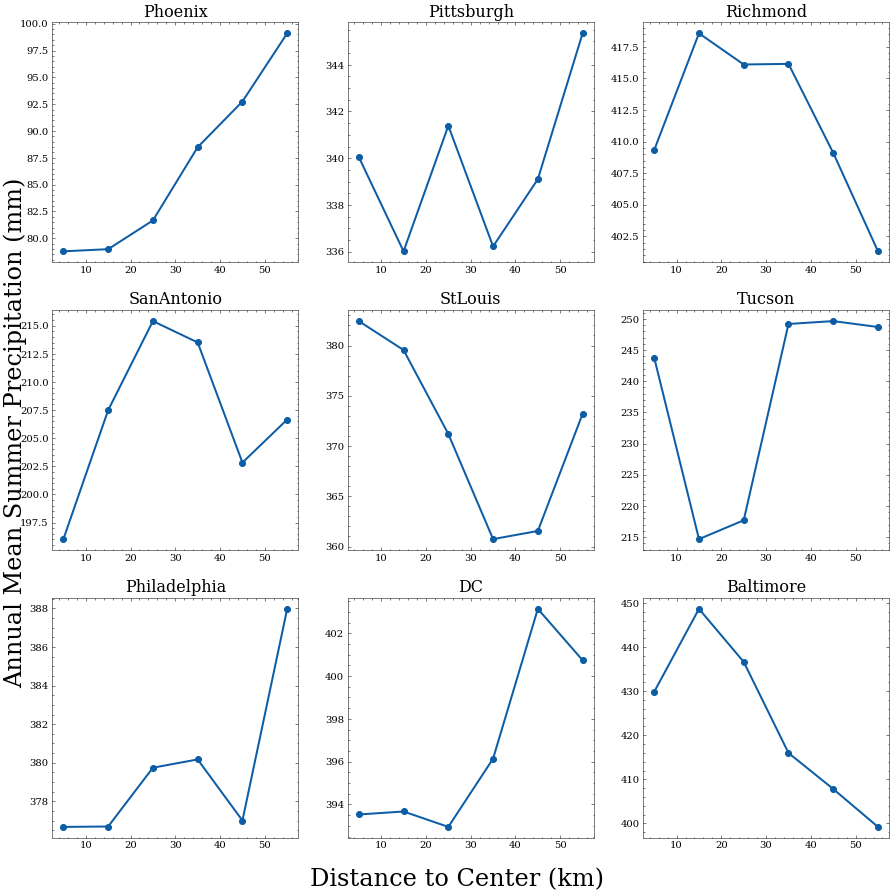

In [8]:
## plot the above cell
os.chdir('/glade/scratch/USERNAME/Rings/')
dat = pd.read_csv('AnnualPrecip_R10_AllDrct.csv', sep = ' ')
x = np.arange(5,65,10)

plt.style.use(['science','no-latex'])
fig,ax = plt.subplots(3,3,figsize=(15,15))
for i,city in enumerate(ls_city[18:27]):
    
    ax[int(np.floor(i/3)),i%3].plot(x,dat[city].tolist(),lw = 2)
    ax[int(np.floor(i/3)),i%3].scatter(x,dat[city].tolist())
    ax[int(np.floor(i/3)),i%3].set_title(city,size=16)
    
fig.text(0.5,0.08,'Distance to Center (km)',size=24,ha='center')
fig.text(0.08,0.5,'Annual Mean Summer Precipitation (mm)',size=24,va='center',rotation='vertical')

In [ ]:
## gradual imp from -60km to 60km (top2 directions)
os.chdir('/glade/scratch/USERNAME/Modis/Results/Imp gradient/')

def rev_drct(x):
    drct = ['E','NE','N','NW','W','SW','S','SE']
    idx = drct.index(x)
    return drct[(idx+4)%len(drct)]

file_allpx = glob("Drct_all*")
file_imppx = glob("Drct_imp*")
# list to store prevailing directions
tmp = pd.read_csv('/glade/scratch/USERNAME/MRMS_PrecipData/T2Drct_SumPrecip60.csv',sep=' ')
ls_drct = tmp['Top 2 drct'].to_list()  # follow the order of cities

df_urban = pd.read_csv('/glade/scratch/zhouyu/Modis/df_urban.csv',sep = ' ')
#print(df_urban['UrbanSize'])

# 27 cities, 20 radius class
df_imp_rate_t2 = pd.DataFrame()
for drct,city in zip(ls_drct,ls_city):
    ls_all_up = []
    ls_imp_up = []
    ls_all_dn = []
    ls_imp_dn = []
    d1 = drct.split('+')[0]
    d2 = drct.split('+')[1]
    for f_all,f_imp in zip(sorted(file_allpx),sorted(file_imppx)):
        df_all = pd.read_csv(f_all,sep = ' ')
        df_imp = pd.read_csv(f_imp,sep = ' ')
        ls_all_up.append(df_all[df_all['City']==city][d1].values[0]+df_all[df_all['City']==city][d2].values[0])
        ls_imp_up.append(df_imp[df_imp['City']==city][d1].values[0]+df_imp[df_imp['City']==city][d2].values[0])
    for f_all,f_imp in zip(sorted(file_allpx),sorted(file_imppx)):
        df_all = pd.read_csv(f_all,sep = ' ')
        df_imp = pd.read_csv(f_imp,sep = ' ')
        ls_all_dn.append(df_all[df_all['City']==city][rev_drct(d1)].values[0]+df_all[df_all['City']==city][rev_drct(d2)].values[0])
        ls_imp_dn.append(df_imp[df_imp['City']==city][rev_drct(d1)].values[0]+df_imp[df_imp['City']==city][rev_drct(d2)].values[0])
    #px_all[city] = ls_all
    imp_rate_up = [ls_imp_up[0]/ls_all_up[0]]
    for k in range(1,len(file_allpx)):
        imp_rate_up.append((ls_imp_up[k]-ls_imp_up[k-1])/(ls_all_up[k]-ls_all_up[k-1]))
    imp_rate_up = imp_rate_up[::-1]
    imp_rate_dn = [ls_imp_dn[0]/ls_all_dn[0]]
    for k in range(1,len(file_allpx)):
        imp_rate_dn.append((ls_imp_dn[k]-ls_imp_dn[k-1])/(ls_all_dn[k]-ls_all_dn[k-1]))
    imp_rate = imp_rate_up+imp_rate_dn
    imp_rate = [round(i,3) for i in imp_rate]
    df_imp_rate_t2[city] = imp_rate
    df_imp_rate_t2[df_imp_rate_t2 < 0] = 0
    
    
## calculate urban size
urb_b03_up = []
urb_b05_up = []
urb_b07_up = []
urb_b03_dn = []
urb_b05_dn = []
urb_b07_dn = []
x = np.arange(-60,60,3)
x_up = [i for i in x if i <= 0]
x_dn = [i for i in x if i >= 0]
frac_imp_up = df_imp_rate_t2.iloc[0:len(x_up)]
frac_imp_dn = df_imp_rate_t2.iloc[len(x_up)-1:]

for city in ls_city:
    ydata_up = frac_imp_up[city].to_list()
    p0_up = [max(ydata_up), np.median(x_up),1,min(ydata_up)]
    popt_up, pcov_up = curve_fit(fsigmoid, x_up, ydata_up, p0_up, maxfev=8000)
    yfit_up = fsigmoid(np.linspace(-60,0,num = 120),*popt_up)
    #if city != 'NYC':
    idx_up = next(x for x,val in enumerate(yfit_up) if val>=0.3)
    urb_b03_up.append(np.linspace(-60,0,num=120)[idx_up])
    idx_up = next(x for x,val in enumerate(yfit_up) if val>=0.5)
    urb_b05_up.append(np.linspace(-60,0,num=120)[idx_up])
    idx_up = next(x for x,val in enumerate(yfit_up) if val>=0.7)
    urb_b07_up.append(np.linspace(-60,0,num=120)[idx_up])
    #else:
    #urb_bound_up.append('NAN')
        
    ydata_dn = frac_imp_dn[city].to_list()
    p0_dn = [max(ydata_dn), np.median(x_dn),1,min(ydata_dn)]
    popt_dn, pcov_dn = curve_fit(fsigmoid, x_dn, ydata_dn, p0_dn, maxfev=8000)
    yfit_dn = fsigmoid(np.linspace(0,60,num = 120),*popt_dn)
    #if city != 'NYC':
    idx_dn = next(x for x,val in enumerate(yfit_dn) if val<=0.3)
    urb_b03_dn.append(np.linspace(0,60,num=120)[idx_dn])
    idx_dn = next(x for x,val in enumerate(yfit_dn) if val<=0.5)
    urb_b05_dn.append(np.linspace(0,60,num=120)[idx_dn])
    idx_dn = next(x for x,val in enumerate(yfit_dn) if val<=0.7)
    urb_b07_dn.append(np.linspace(0,60,num=120)[idx_dn])
    #else:
    #urb_bound_dn.append('NAN')
        
df_urban['upper03'] = urb_b03_up
df_urban['lower03'] = urb_b03_dn
df_urban['upper05'] = urb_b05_up
df_urban['lower05'] = urb_b05_dn
df_urban['upper07'] = urb_b07_up
df_urban['lower07'] = urb_b07_dn
df_urban['FullSize03'] = [i-j for i,j in zip(urb_b03_dn,urb_b03_up)]
df_urban['FullSize05'] = [i-j for i,j in zip(urb_b05_dn,urb_b05_up)]
df_urban['FullSize07'] = [i-j for i,j in zip(urb_b07_dn,urb_b07_up)]
df_urban = df_urban.sort_values('FullSize03')
print(df_urban)

## Ring-based precipitation

Text(0.08, 0.5, 'Normalized Annual Mean Summer Precipitation')

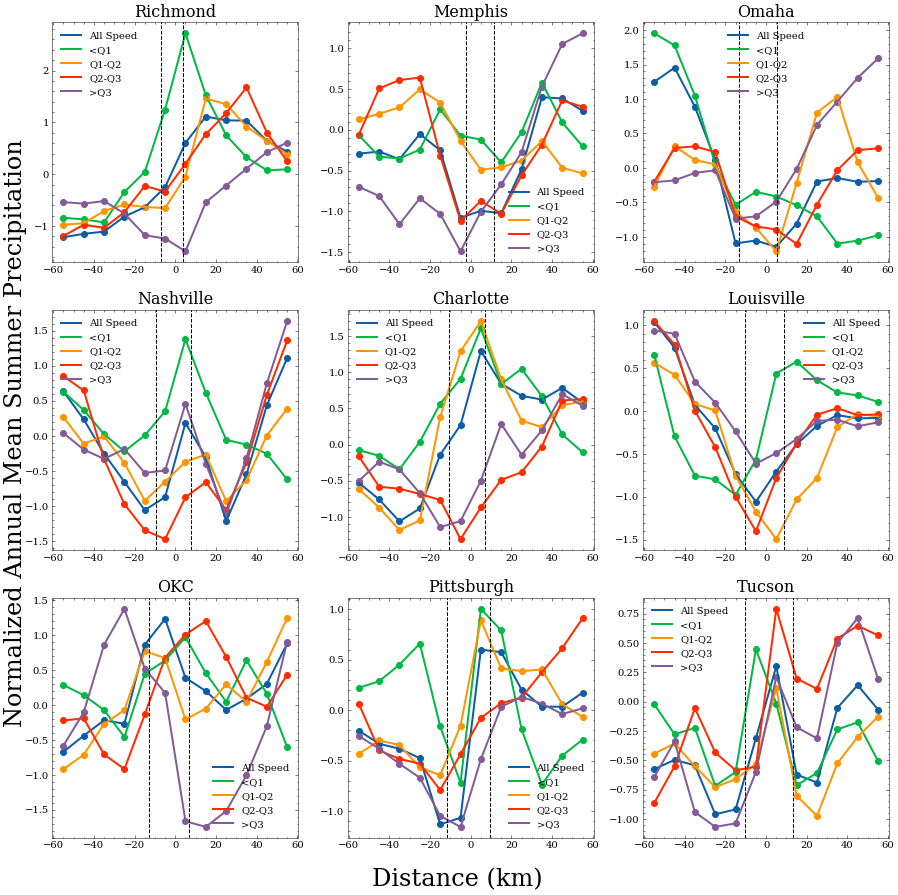

In [25]:
## All wind
os.chdir('/glade/scratch/USERNAME/Rings')
plt.style.use(['science','no-latex'])
df_rPrecipUp = pd.read_csv('./AnnualPrecip_R10Up_Normed.csv',sep = ' ') # reverse the order to get data of precip from -60km to 0
df_rPrecipDn = pd.read_csv('./AnnualPrecip_R10Dn_Normed.csv',sep = ' ')
df_rPrecipUp_Q1 = pd.read_csv('./AnnualPrecip_R10Up_Q1Normed.csv',sep = ' ') 
df_rPrecipDn_Q1 = pd.read_csv('./AnnualPrecip_R10Dn_Q1Normed.csv',sep = ' ')
df_rPrecipUp_Q2 = pd.read_csv('./AnnualPrecip_R10Up_Q2Normed.csv',sep = ' ') 
df_rPrecipDn_Q2 = pd.read_csv('./AnnualPrecip_R10Dn_Q2Normed.csv',sep = ' ')
df_rPrecipUp_Q3 = pd.read_csv('./AnnualPrecip_R10Up_Q3Normed.csv',sep = ' ') 
df_rPrecipDn_Q3 = pd.read_csv('./AnnualPrecip_R10Dn_Q3Normed.csv',sep = ' ')
df_rPrecipUp_Q4 = pd.read_csv('./AnnualPrecip_R10Up_Q4Normed.csv',sep = ' ') 
df_rPrecipDn_Q4 = pd.read_csv('./AnnualPrecip_R10Dn_Q4Normed.csv',sep = ' ')
df_urban = pd.read_csv('/glade/scratch/zhouyu/Modis/df_urban2.csv',sep = ' ')
#df_rPrecip = pd.concat([df_rPrecipUp,df_rPrecipDn],ignore_index=True)

group_sig = ['DC','Philadelphia','StLouis','Houston']+['Baltimore','Dallas','KC','Charlotte','Orlando','Minneapolis'] \
+['Memphis','Austin','Columbus','Cincinnati','Omaha','SanAntonio']
group_nonsig = ['NYC','Phoenix','Pittsburgh','Atlanta','OKC','Richmond','Miami','Nashville','Tucson','Indianapolis','Louisville']

x = np.arange(-55,65,10)
x2 = np.arange(-60,60,3)
fig,ax = plt.subplots(3,3,figsize=(15,15))
for i,city in enumerate(df_urban['City'].tolist()[0:9]):
    
    #params,cov = curve_fit(fGauss,x2,df_imp_rate_t2[city].to_list(),maxfev = 8000)
    #yfit = fGauss(x2,*params)
    #ax[int(np.floor(i/3)),i%3].plot(np.linspace(-60,60,num = 240),fGauss(np.linspace(-60,60,num = 240),*params)*300,'r-')
    ax[int(np.floor(i/3)),i%3].plot(x,df_rPrecipUp[city][::-1].tolist()+df_rPrecipDn[city].tolist(),lw = 2,label='All Speed')
    ax[int(np.floor(i/3)),i%3].scatter(x,df_rPrecipUp[city][::-1].tolist()+df_rPrecipDn[city].tolist())
    ax[int(np.floor(i/3)),i%3].plot(x,df_rPrecipUp_Q1[city][::-1].tolist()+df_rPrecipDn_Q1[city].tolist(),lw = 2,label='<Q1')
    ax[int(np.floor(i/3)),i%3].scatter(x,df_rPrecipUp_Q1[city][::-1].tolist()+df_rPrecipDn_Q1[city].tolist())
    ax[int(np.floor(i/3)),i%3].plot(x,df_rPrecipUp_Q2[city][::-1].tolist()+df_rPrecipDn_Q2[city].tolist(),lw = 2,label='Q1-Q2')
    ax[int(np.floor(i/3)),i%3].scatter(x,df_rPrecipUp_Q2[city][::-1].tolist()+df_rPrecipDn_Q2[city].tolist())
    ax[int(np.floor(i/3)),i%3].plot(x,df_rPrecipUp_Q3[city][::-1].tolist()+df_rPrecipDn_Q3[city].tolist(),lw = 2,label='Q2-Q3')
    ax[int(np.floor(i/3)),i%3].scatter(x,df_rPrecipUp_Q3[city][::-1].tolist()+df_rPrecipDn_Q3[city].tolist())
    ax[int(np.floor(i/3)),i%3].plot(x,df_rPrecipUp_Q4[city][::-1].tolist()+df_rPrecipDn_Q4[city].tolist(),lw = 2,label='>Q3')
    ax[int(np.floor(i/3)),i%3].scatter(x,df_rPrecipUp_Q4[city][::-1].tolist()+df_rPrecipDn_Q4[city].tolist())
    ax[int(np.floor(i/3)),i%3].set_title(city,size=16)
    ax[int(np.floor(i/3)),i%3].legend()
    #if city in group_sig:
    #    ax[int(np.floor(i/3)),i%3].set_title(city,size=16,color='red')
        
    #if city != 'NYC':
    ax[int(np.floor(i/3)),i%3].axvline(x=df_urban[df_urban['City']==city]['upper05'].values,ls='--',c='k')
    ax[int(np.floor(i/3)),i%3].axvline(x=df_urban[df_urban['City']==city]['lower05'].values,ls='--',c='k')
    
fig.text(0.5,0.08,'Distance (km)',size=24,ha='center')
fig.text(0.08,0.5,'Normalized Annual Mean Summer Precipitation',size=24,va='center',rotation='vertical')

Text(0.08, 0.5, 'Annual Mean Summer Precipitation (mm)')

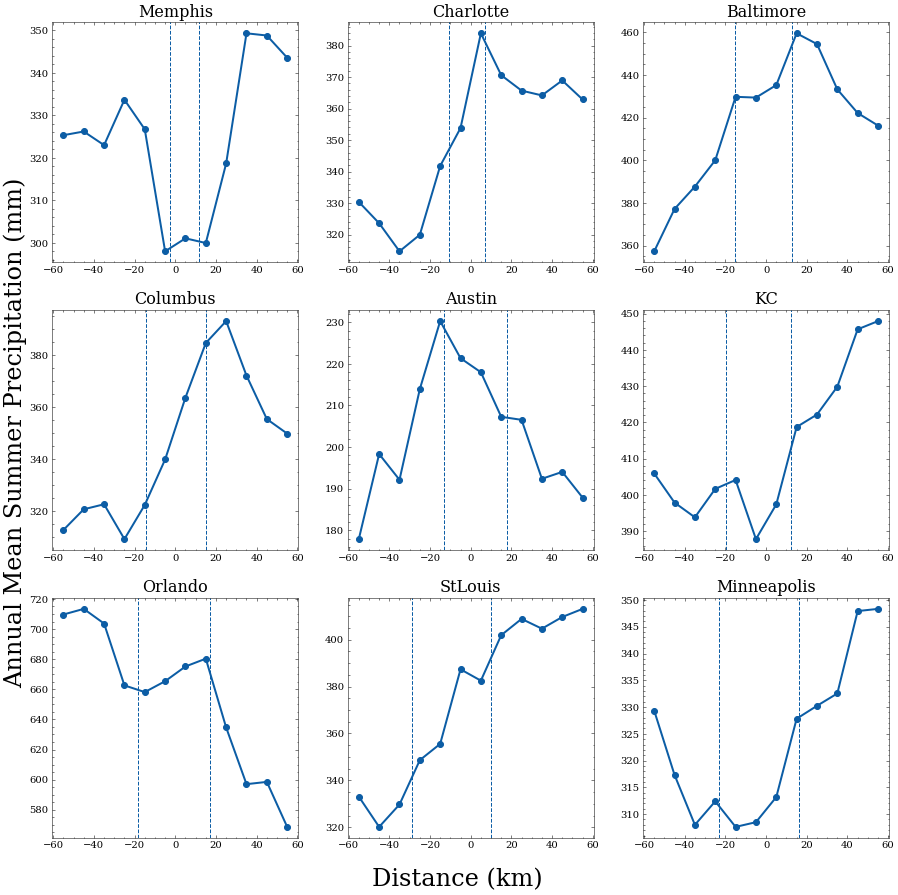

In [17]:
## significant, positive DEI plotting ()


os.chdir('/glade/scratch/USERNAME/Rings')
plt.style.use(['science','no-latex'])
df_rPrecipUp = pd.read_csv('./AnnualPrecip_R10Up.csv',sep = ' ') # reverse the order to get data of precip from -60km to 0
df_rPrecipDn = pd.read_csv('./AnnualPrecip_R10Dn.csv',sep = ' ')

df_urban = pd.read_csv('/glade/scratch/USERNAME/Modis/df_urban2.csv',sep = ' ')

group_possig = ['Austin','Baltimore','Charlotte','Columbus','Dallas','DC','Houston','KC','Memphis','Minneapolis','Orlando',
               'Philadelphia','StLouis']

df_urban = df_urban[df_urban['City'].isin(group_possig)]
#print(df_urban)
### first 9 cities.
x = np.arange(-55,65,10)
x2 = np.arange(-60,60,3)
fig,ax = plt.subplots(3,3,figsize=(15,15))
for i,city in enumerate(df_urban['City'].tolist()[0:9]):
    ax[int(np.floor(i/3)),i%3].plot(x,df_rPrecipUp[city][::-1].tolist()+df_rPrecipDn[city].tolist(),lw = 2)
    ax[int(np.floor(i/3)),i%3].scatter(x,df_rPrecipUp[city][::-1].tolist()+df_rPrecipDn[city].tolist())
    ax[int(np.floor(i/3)),i%3].set_title(city,size=16)
    ax[int(np.floor(i/3)),i%3].axvline(x=df_urban[df_urban['City']==city]['upper_bound'].values,ls='--')
    ax[int(np.floor(i/3)),i%3].axvline(x=df_urban[df_urban['City']==city]['lower_bound'].values,ls='--')
    
fig.text(0.5,0.08,'Distance (km)',size=24,ha='center')
fig.text(0.08,0.5,'Annual Mean Summer Precipitation (mm)',size=24,va='center',rotation='vertical')

Text(0.06, 0.5, 'Annual Mean Summer Precipitation (mm)')

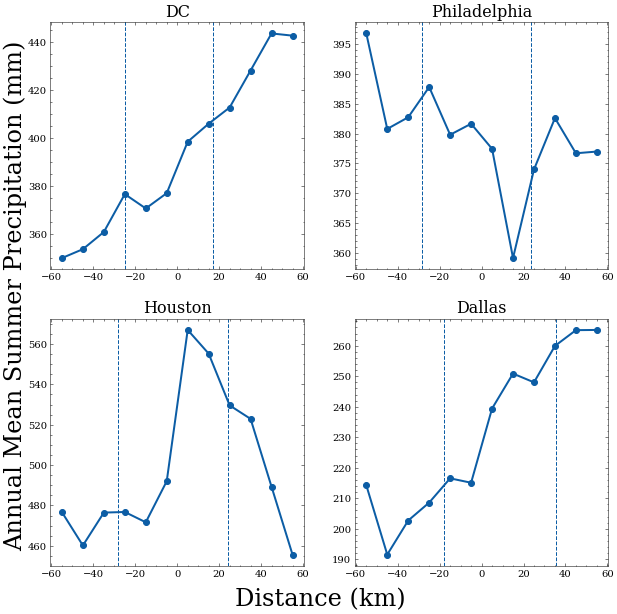

In [24]:
### last 4 cities.
x = np.arange(-55,65,10)
x2 = np.arange(-60,60,3)
fig,ax = plt.subplots(2,2,figsize=(10,10))
for i,city in enumerate(df_urban['City'].tolist()[9:]):
    ax[int(np.floor(i/2)),i%2].plot(x,df_rPrecipUp[city][::-1].tolist()+df_rPrecipDn[city].tolist(),lw = 2)
    ax[int(np.floor(i/2)),i%2].scatter(x,df_rPrecipUp[city][::-1].tolist()+df_rPrecipDn[city].tolist())
    ax[int(np.floor(i/2)),i%2].set_title(city,size=16)
    ax[int(np.floor(i/2)),i%2].axvline(x=df_urban[df_urban['City']==city]['upper_bound'].values,ls='--')
    ax[int(np.floor(i/2)),i%2].axvline(x=df_urban[df_urban['City']==city]['lower_bound'].values,ls='--')
    
fig.text(0.5,0.07,'Distance (km)',size=24,ha='center')
fig.text(0.06,0.5,'Annual Mean Summer Precipitation (mm)',size=24,va='center',rotation='vertical')

In [3]:
# normalization of ring-based mean precipitation
os.chdir('/glade/scratch/USERNAME/MRMS_PrecipData/')

ls_city = ['Atlanta','Austin','Charlotte','Cincinnati','Columbus','Dallas','Houston','Indianapolis','KC','Louisville',
           'Memphis','Miami','Minneapolis','Nashville','NYC','OKC','Omaha','Orlando','Phoenix','Pittsburgh',
           'Richmond','SanAntonio','StLouis','Tucson','Philadelphia','DC','Baltimore']

df_urban = pd.read_csv('/glade/scratch/USERNAME/Modis/df_urban2.csv',sep = ' ')
df_urban = df_urban.sort_values('FullSize05')

df_domain = pd.DataFrame()

ls_mean = []
ls_std = []
for city in ls_city:
    ras = rxr.open_rasterio('./Precip_map/'+city+'_PrecipMap60.tif')
    ras = ras[0]/7
    ls_mean.append(ras.mean().values)
    ls_std.append(ras.std().values)
df_domain['City'] = ls_city
df_domain['Mean'] = ls_mean
df_domain['Std'] = ls_std

group_possig = ['Austin','Baltimore','Charlotte','Columbus','Dallas','DC','Houston','KC','Memphis','Minneapolis','Orlando',
               'Philadelphia','StLouis']
df_domain = df_domain[df_domain['City'].isin(group_possig)] # filter cities with postive and significant DEI
df_urban = df_urban[df_urban['City'].isin(group_possig)]

df_rPrecipUp = pd.read_csv('../Rings/AnnualPrecip_R10Up.csv',sep = ' ') # reverse the order to get data of precip from -60km to 0
df_rPrecipDn = pd.read_csv('../Rings/AnnualPrecip_R10Dn.csv',sep = ' ')
    

In [4]:
print(df_urban)

    Unnamed: 0  Unnamed: 0.1          City       DEI           UrbanSize  \
1           10            10       Memphis  0.107496    2.52100840336135   
4            2             2     Charlotte  0.138572  10.588235294117652   
12          26            26     Baltimore  0.311297   15.12605042016807   
11           4             4      Columbus  0.165762  14.621848739495803   
15           1             1        Austin  0.191504  13.109243697478995   
16           8             8            KC  0.192311   19.66386554621849   
17          17            17       Orlando  0.148088   18.15126050420168   
19          22            22       StLouis  0.197990   28.73949579831933   
18          12            12   Minneapolis  0.071139  23.193277310924373   
20          25            25            DC  0.308956  24.705882352941174   
23          24            24  Philadelphia  0.172920  28.235294117647058   
25           6             6       Houston  0.200647  28.235294117647058   
24          

Text(0.06, 0.5, 'Normalized Ring-averaged Precipitation')

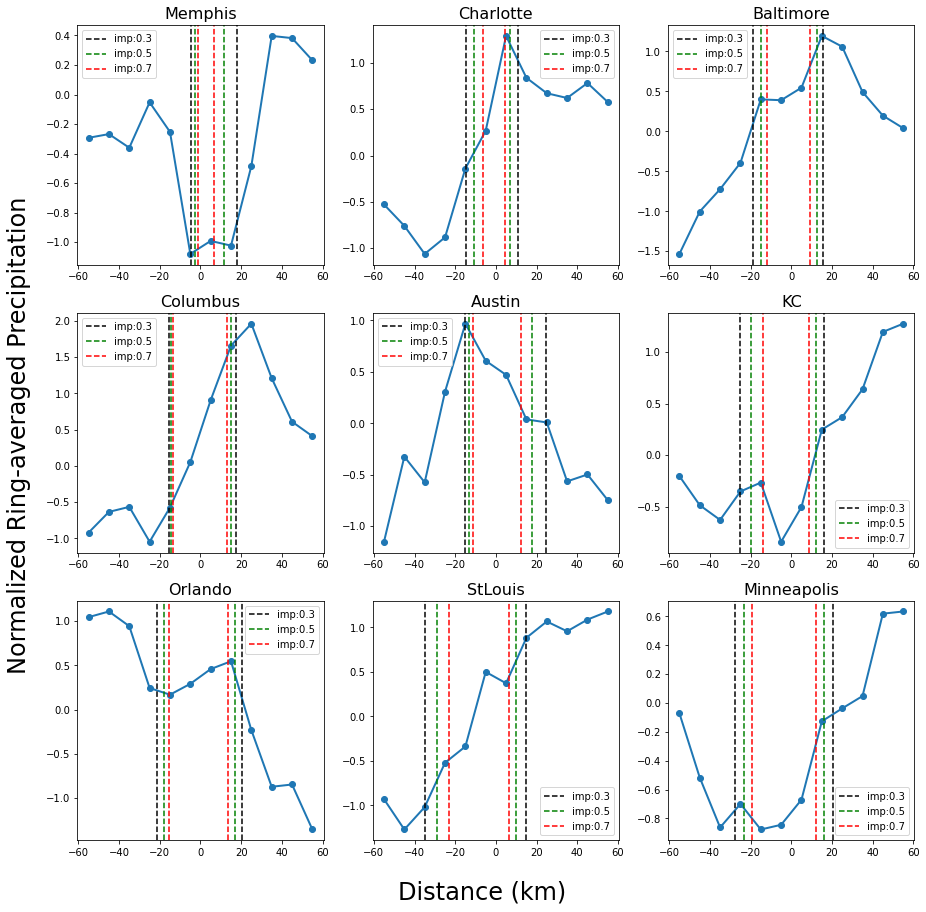

In [16]:
x = np.arange(-55,65,10)
x2 = np.arange(-60,60,3)

fig,ax = plt.subplots(3,3,figsize=(15,15))
for i,city in enumerate(df_urban['City'].tolist()[:9]):
    
    res = df_rPrecipUp[city][::-1].tolist()+df_rPrecipDn[city].tolist()
    res = [(i-df_domain[df_domain['City'] == city]['Mean'].values)/df_domain[df_domain['City'] == city]['Std'].values for i \
          in res]
    
    ax[int(np.floor(i/3)),i%3].plot(x,res,lw = 2)
    ax[int(np.floor(i/3)),i%3].scatter(x,res)
    ax[int(np.floor(i/3)),i%3].set_title(city,size=16)
    ax[int(np.floor(i/3)),i%3].axvline(x=df_urban[df_urban['City']==city]['upper03'].values,ls='--',c='k',label='imp:0.3')
    ax[int(np.floor(i/3)),i%3].axvline(x=df_urban[df_urban['City']==city]['lower03'].values,ls='--',c='k')
    ax[int(np.floor(i/3)),i%3].axvline(x=df_urban[df_urban['City']==city]['upper05'].values,ls='--',c='g',label='imp:0.5')
    ax[int(np.floor(i/3)),i%3].axvline(x=df_urban[df_urban['City']==city]['lower05'].values,ls='--',c='g')
    ax[int(np.floor(i/3)),i%3].axvline(x=df_urban[df_urban['City']==city]['upper07'].values,ls='--',c='r',label='imp:0.7')
    ax[int(np.floor(i/3)),i%3].axvline(x=df_urban[df_urban['City']==city]['lower07'].values,ls='--',c='r')
    ax[int(np.floor(i/3)),i%3].legend()
    
fig.text(0.5,0.07,'Distance (km)',size=24,ha='center')
fig.text(0.06,0.5,'Normalized Ring-averaged Precipitation',size=24,va='center',rotation='vertical')

Text(0.04, 0.5, 'Normalized Ring-averaged Precipitation')

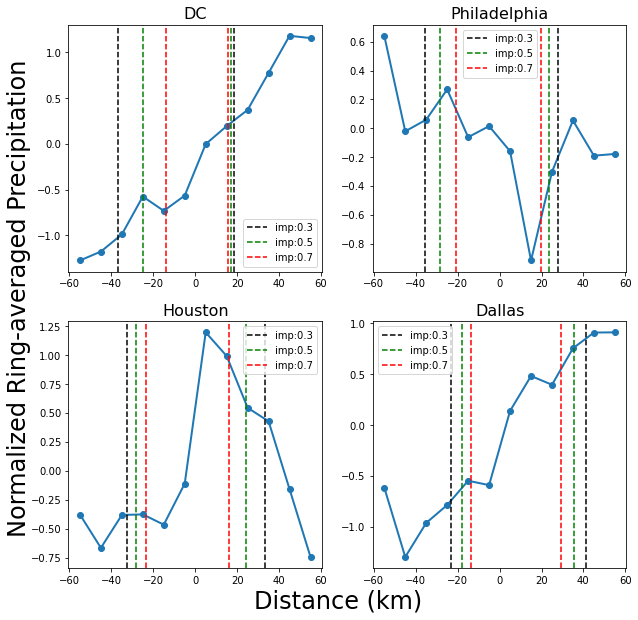

In [18]:
x = np.arange(-55,65,10)
x2 = np.arange(-60,60,3)

fig,ax = plt.subplots(2,2,figsize=(10,10))
for i,city in enumerate(df_urban['City'].tolist()[9:]):
    
    res = df_rPrecipUp[city][::-1].tolist()+df_rPrecipDn[city].tolist()
    res = [(i-df_domain[df_domain['City'] == city]['Mean'].values)/df_domain[df_domain['City'] == city]['Std'].values for i \
          in res]
    
    ax[int(np.floor(i/2)),i%2].plot(x,res,lw = 2)
    ax[int(np.floor(i/2)),i%2].scatter(x,res)
    ax[int(np.floor(i/2)),i%2].set_title(city,size=16)
    ax[int(np.floor(i/2)),i%2].axvline(x=df_urban[df_urban['City']==city]['upper03'].values,ls='--',c='k',label='imp:0.3')
    ax[int(np.floor(i/2)),i%2].axvline(x=df_urban[df_urban['City']==city]['lower03'].values,ls='--',c='k')
    ax[int(np.floor(i/2)),i%2].axvline(x=df_urban[df_urban['City']==city]['upper05'].values,ls='--',c='g',label='imp:0.5')
    ax[int(np.floor(i/2)),i%2].axvline(x=df_urban[df_urban['City']==city]['lower05'].values,ls='--',c='g')
    ax[int(np.floor(i/2)),i%2].axvline(x=df_urban[df_urban['City']==city]['upper07'].values,ls='--',c='r',label='imp:0.7')
    ax[int(np.floor(i/2)),i%2].axvline(x=df_urban[df_urban['City']==city]['lower07'].values,ls='--',c='r')
    ax[int(np.floor(i/2)),i%2].legend()
    
fig.text(0.5,0.07,'Distance (km)',size=24,ha='center')
fig.text(0.04,0.5,'Normalized Ring-averaged Precipitation',size=24,va='center',rotation='vertical')